# min_dR allYrs

So, Sean showed that we have a good *improvement* when using the shifted SR, although it *was* curious that we didn't see as large of an improvement for 2018 as the other years. Sean's sort of parsing this out rn,  but the *open Q* from our side was what the signal distributions looked like for each of the years, and while I'm at it, Rafael *also* asked me to monitor the 

1. $\sigma$
2. IQR corresponding to the 68.5% range


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot

from statsmodels.stats.weightstats import DescrStatsW
# import weighted

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os

os.sys.path+= ['../RRevolution/code/','../code/']
from utils import mcToYr

from eventDisplays import rainbow_text

from plots import draw_SR, draw_VR, draw_CR

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


### Step 1: Load in the data

In [3]:
sort = 'Db_sort'
prodTag='JUN20'
pairing='min_dR1'

In [4]:
mc16a = pd.read_parquet(f'../data/SMNR_mc16a-{prodTag}/df_{pairing}_{sort}_VEC.parquet') 
mc16d = pd.read_parquet(f'../data/SMNR_mc16d-{prodTag}/df_{pairing}_{sort}_VEC.parquet')
mc16e = pd.read_parquet(f'../data/SMNR_mc16e-{prodTag}/df_{pairing}_{sort}_VEC.parquet')

In [5]:
k10a = pd.read_parquet(f'../data/k10_mc16a-{prodTag}/df_{pairing}_{sort}_VEC.parquet') 
k10d = pd.read_parquet(f'../data/k10_mc16d-{prodTag}/df_{pairing}_{sort}_VEC.parquet')
k10e = pd.read_parquet(f'../data/k10_mc16e-{prodTag}/df_{pairing}_{sort}_VEC.parquet')

In [6]:
for df in [mc16a,mc16d,mc16e,k10a,k10d,k10e]:
    df['minQ'] = np.min(df[[f'Db_h{i}_j{j}' for i,j in product([1,2],[1,2])]],axis=1)

### Step 2: Get the marginals

B/c this is what Sean wants to feed into the circles optimization plot.

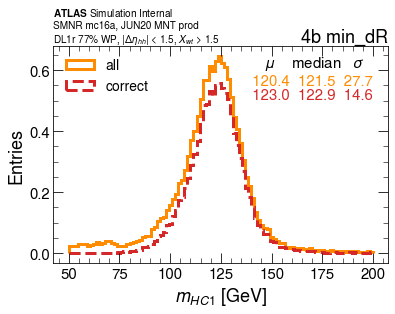

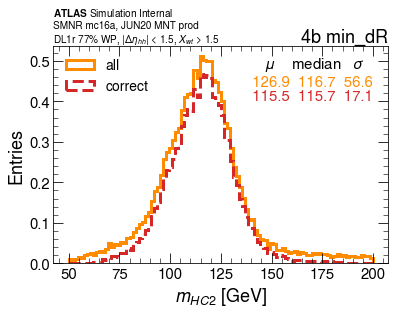

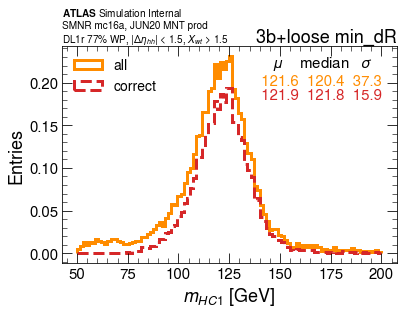

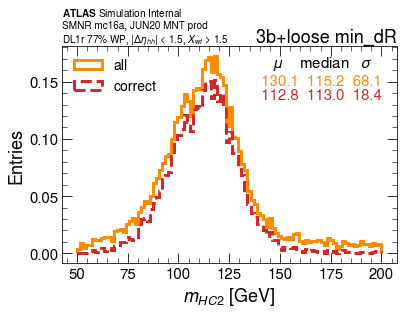

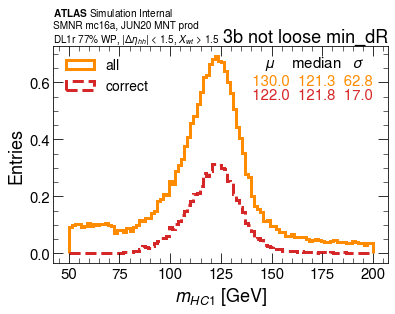

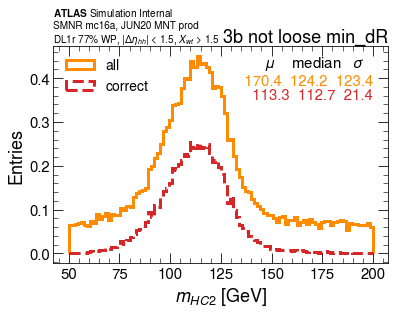

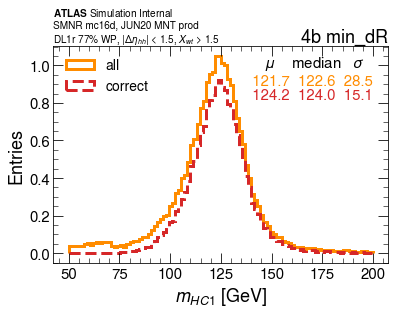

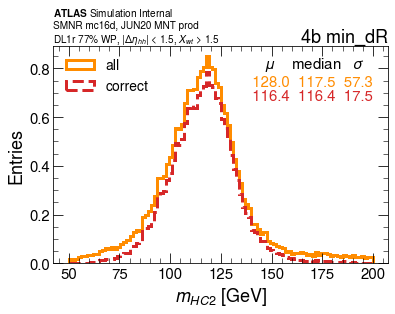

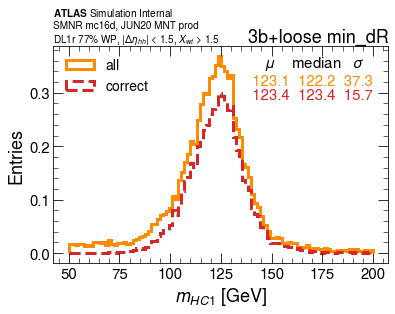

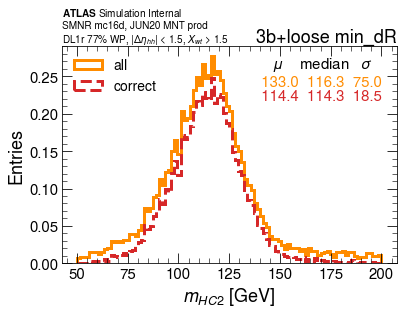

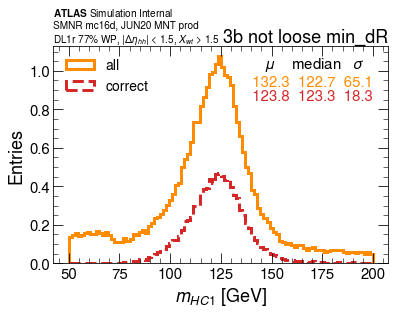

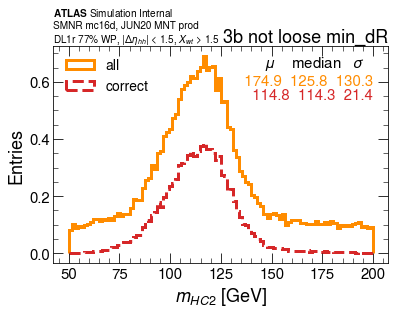

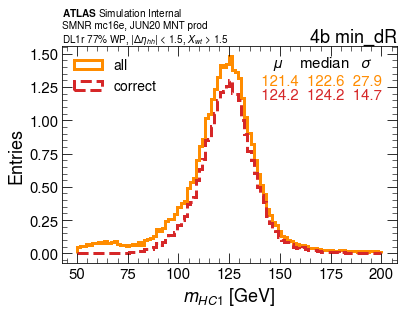

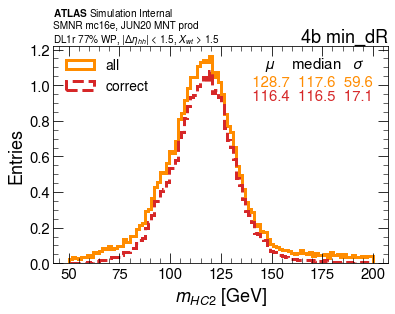

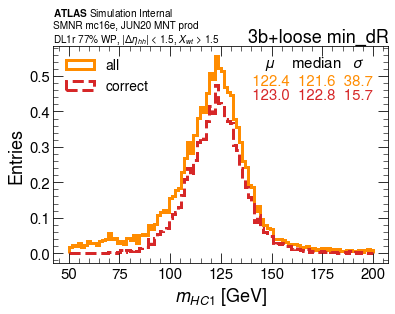

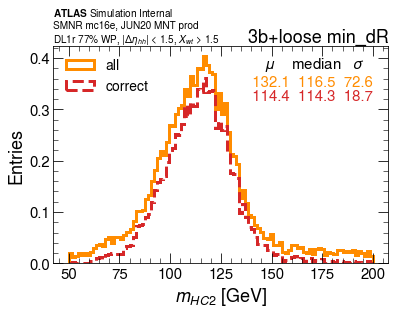

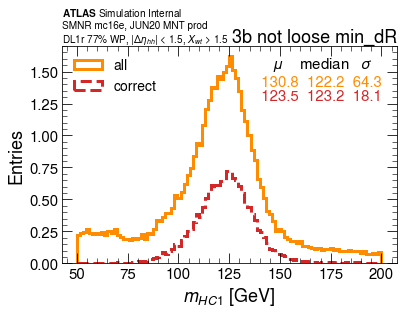

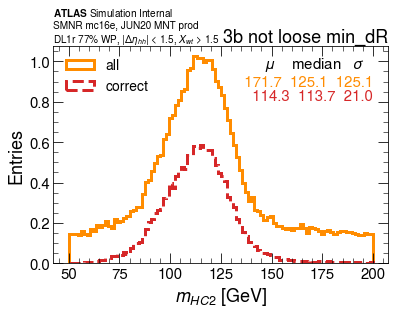

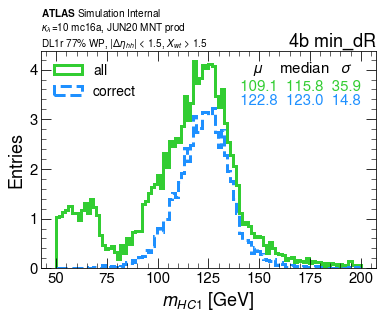

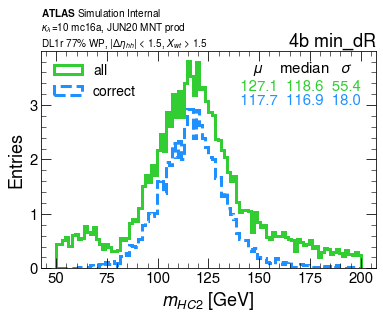

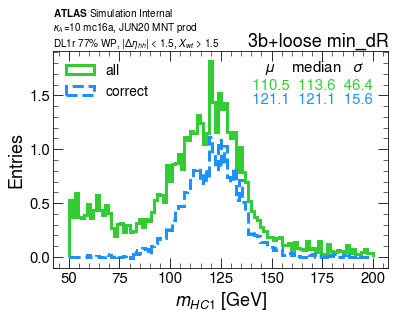

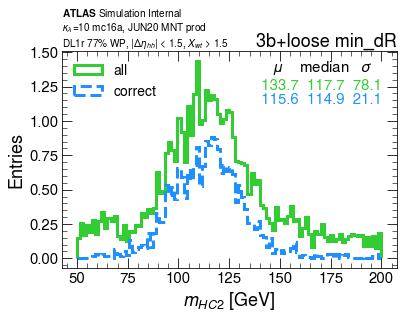

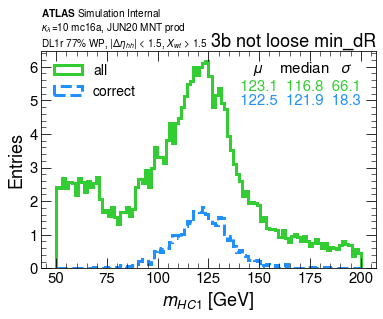

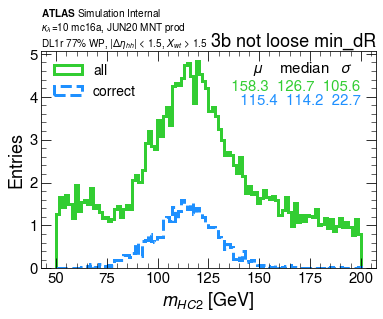

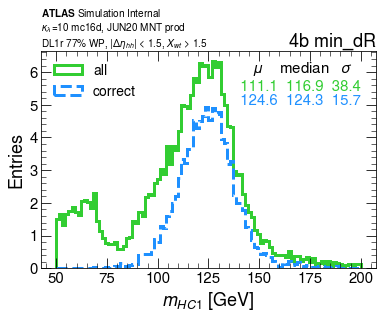

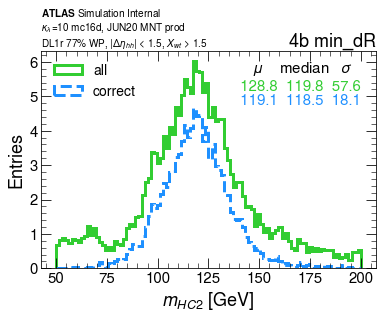

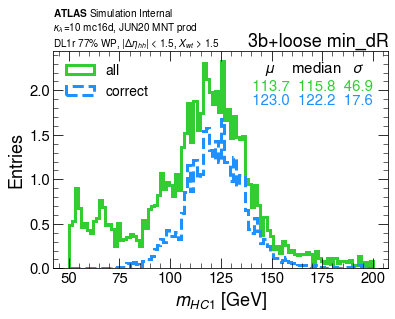

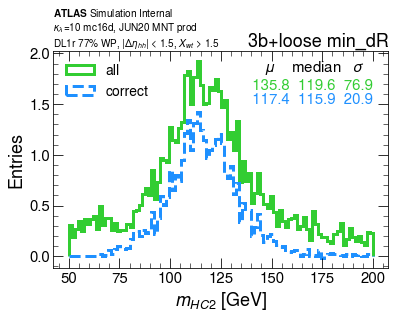

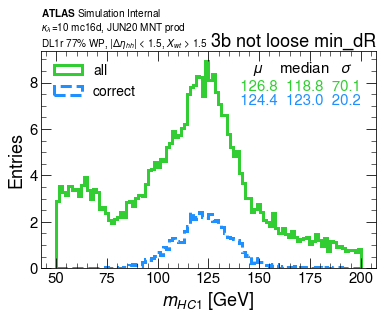

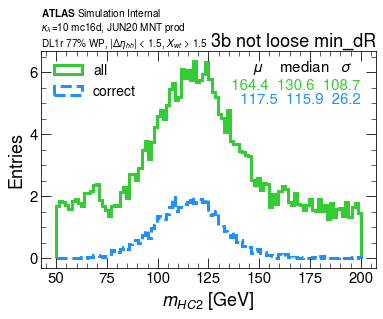

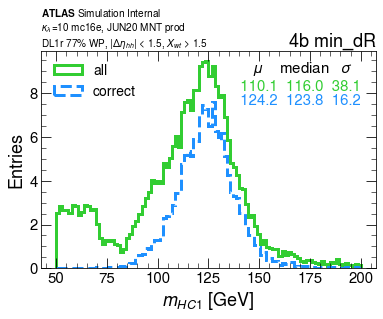

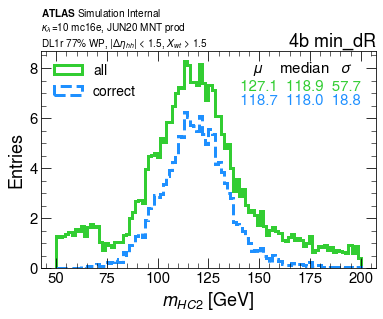

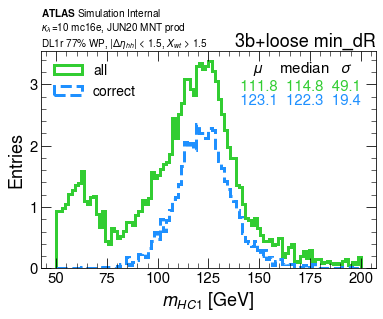

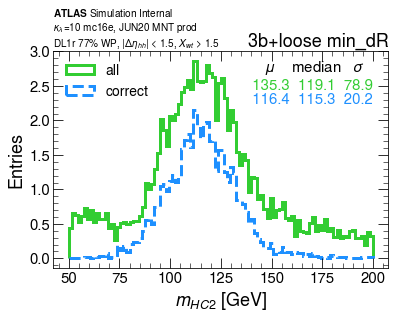

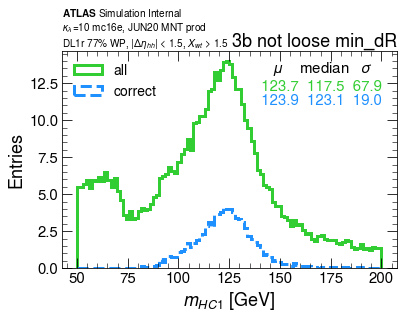

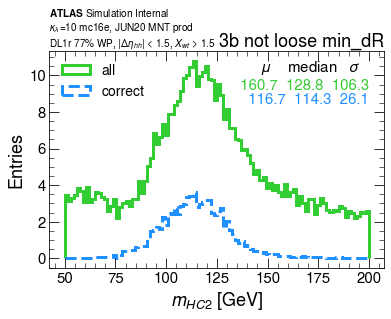

In [6]:
title='min_dR'
lw=3

for physicsSample, dfs, c0,c1 in zip(['SMNR','k10'],[[mc16a,mc16d,mc16e],[k10a,k10d,k10e]],
                                     ['darkorange','limegreen'],['C3','dodgerblue']):

    ps = physicsSample if physicsSample == 'SMNR' else f'$\kappa_\lambda$={physicsSample[1:]}'

    lc = ['k', c0, c1]
    
    for mc,df in zip(['mc16a','mc16d','mc16e'],dfs):

        fmp = "$\mathbf{ATLAS}$ Simulation Internal\n"
        fmp += f"{ps} {mc}, {prodTag} MNT prod\n"
        fmp += "DL1r 77% WP, $|\Delta \eta_{hh}|$ < 1.5, $X_{wt}$ > 1.5"

        for ntag, mi,titleTag,tag in zip([4,3,3], [(df.ntag>=4),(df.minQ==2),(df.minQ==1)],
                                         ['','+loose',' not loose'],['','loose','notLoose']):
            
            bmask = (df.ntag>=4) if ntag ==4 else (df.ntag==ntag)
            
            m = bmask & mi & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

            for c in ['m_h1','m_h2']:

                plt.figure()
                plt.hist(df.loc[m,c], 100,(50,200),label='all',ls='-',lw=lw,
                         color=c0,histtype='step',
                         weights=df.loc[m ,'mc_sf'])

                plt.hist(df.loc[m & (df.chosenPair==df.correctPair),c],
                         100,(50,200),label='correct',ls='--',lw=lw,
                         color=c1,histtype='step',
                         weights=df.loc[m & (df.chosenPair==df.correctPair),'mc_sf'])

                hc_text = ['$\mu$    median   $\sigma$   ']
                for mask in [m, m&(df.chosenPair==df.correctPair)]:

                    v,w = df.loc[mask,[c,'mc_sf']].values.T

                    weighted_stats = DescrStatsW(v, weights=w, ddof=0)

                    mu = weighted_stats.mean
                    median = weighted_stats.quantile(.5).values[0]
                    std = weighted_stats.std

                    hc_text.append(f'{mu : .1f} {median: .1f} {std: .1f}')

                plt.xlabel('$m_{HC'+f'{c[-1]}'+'}$ [GeV]',fontsize=18)
                plt.ylabel('Entries',fontsize=18)
                plt.legend(loc='upper left')

                ax = plt.gca()
                plt.title(f'{ntag}b{titleTag} {title}',transform=ax.transAxes,loc='right')
                plt.text(0,1,fmp,transform=ax.transAxes,ha='left',va='bottom',fontsize=10)
                rainbow_text(200, 0.9*plt.ylim()[1], hc_text, lc, ax=ax,ha='right', yoffset=1)

                figDir = f'figures/{physicsSample}_{mc}-{prodTag}/{title}'
                if not os.path.exists(figDir): os.mkdir(figDir)

                plt.savefig(f'{figDir}/{c}_{ntag}b{tag}_Xwt.pdf', bbox_inches='tight')

        plt.show()

**Cool:** So, I think these are some good summary metrics, but to delve in to a little more detail, let's *zoom* in on 4b rn, and check the $\mu$, median, $\sigma$, 68% IQR

And *then* slice in m_h1, m_h2 bins and do the same study?

In [7]:
m_edg = np.arange(100,150,10)
m_edg

array([100, 110, 120, 130, 140])

In [8]:
m_mids = 0.5 * (m_edg[1:]+m_edg[:-1])

In [9]:
df = mc16d

m = (df.ntag>=4) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5) & (df.chosenPair==df.correctPair)

In [10]:
mu1s = []
std1s = []

mu2s = []
std2s = []

for m_min, m_min, m_max in zip(m_mids, m_edg[:-1], m_edg[1:]):
    
    # mask m_h1, calc stats for m_h2
    m_h1_bin = m & (df.m_h1 > m_min) & (df.m_h1 < m_max)
    
    weighted_stats = DescrStatsW(df.loc[m_h1_bin,'m_h2'], 
                                 weights=df.loc[m_h1_bin,'mc_sf'], ddof=0)
    
    mu2s.append(weighted_stats.mean)
    std2s.append(weighted_stats.std)
    
    
    # mask m_h2, calc stats for m_h2
    m_h2_bin = m & (df.m_h2 > m_min) & (df.m_h2 < m_max)
    
    weighted_stats = DescrStatsW(df.loc[m_h2_bin,'m_h1'], 
                                 weights=df.loc[m_h2_bin,'mc_sf'], ddof=0)
    
    mu1s.append(weighted_stats.mean)
    std1s.append(weighted_stats.std)
    

Text(0.5, 0, 'mass bin center \\other\\ HC [GeV]')

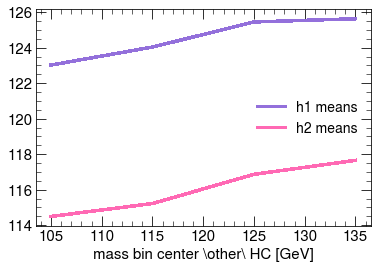

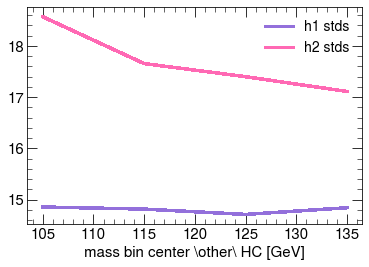

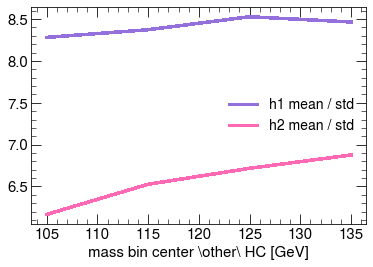

In [11]:
plt.figure()

plt.plot(m_mids,mu1s,color='mediumpurple',label='h1 means')
plt.plot(m_mids,mu2s,color='hotpink',label='h2 means')
plt.legend()
plt.xlabel('mass bin center \other\ HC [GeV]')

plt.figure()

plt.plot(m_mids,std1s,color='mediumpurple',label='h1 stds')
plt.plot(m_mids,std2s,color='hotpink',label='h2 stds')
plt.legend()
plt.xlabel('mass bin center \other\ HC [GeV]')

plt.figure()
plt.plot(m_mids,np.array(mu1s)/np.array(std1s),color='mediumpurple',label='h1 mean / std')
plt.plot(m_mids,np.array(mu2s)/np.array(std2s),color='hotpink',     label='h2 mean / std')
plt.legend()
plt.xlabel('mass bin center \other\ HC [GeV]')

Ok, there is *not* a clear relation b/w one HC mass and the resolution on the other.

Side note: Rafael also wanted me to compare the 68% IQR range as well.

In [12]:
idx = [f'{ps} mc16{i}' for ps,i in product(['SMNR','k10'],['a','d','e'])]
cols = [f'm_h{i} {v}' for i,v in product([1,2],['mu','median','std','1/2 68% IQR','34% dn','34% up'])]

sumStats = pd.DataFrame(0,idx,cols)

In [13]:
for physicsSample, dfs in zip(['SMNR','k10'],[[mc16a,mc16d,mc16e],[k10a,k10d,k10e]]):
    
    for mc,df in zip(['mc16a','mc16d','mc16e'],dfs):
        
        i = f'{physicsSample} {mc}'
        
        m = (df.ntag>=4) & (df.chosenPair==df.correctPair) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)
        
        for c in ['m_h1','m_h2']:

            v,w = df.loc[m,[c,'mc_sf']].values.T

            weighted_stats = DescrStatsW(v, weights=w, ddof=0)

            sumStats.loc[i,f'{c} mu']     = weighted_stats.mean
            sumStats.loc[i,f'{c} std']    = weighted_stats.std
            
            median = weighted_stats.quantile(.5).values
            q_dn = weighted_stats.quantile(.5-.3414).values
            q_up = weighted_stats.quantile(.5+.3414).values
            
            
            sumStats.loc[i,f'{c} median'] = median
            
            sumStats.loc[i,f'{c} 34% dn'] = median-q_dn
            sumStats.loc[i,f'{c} 34% up'] = q_up-median
            sumStats.loc[i,f'{c} 1/2 68% IQR'] = (q_up-q_dn)/2
            

In [14]:
sumStats[[c for c in cols if ('mu' in c) or ('median' in c)]]

m_h1 mu  m_h1 median     m_h2 mu  m_h2 median
SMNR mc16a  123.025667   122.902644  115.457075   115.652816
SMNR mc16d  124.205908   123.964213  116.365344   116.374321
SMNR mc16e  124.224074   124.151289  116.430194   116.472863
k10 mc16a   122.820414   123.040220  117.680835   116.940810
k10 mc16d   124.624732   124.323075  119.106611   118.477475
k10 mc16e   124.197001   123.825733  118.674404   117.974359

In [15]:
sumStats[[c for c in cols if ('mu' not in c) and ('median' not in c)]]

m_h1 std  m_h1 1/2 68% IQR  m_h1 34% dn  m_h1 34% up   m_h2 std  \
SMNR mc16a  14.635814         12.169566    12.523051    11.816082  17.082788   
SMNR mc16d  15.121832         12.613930    12.913866    12.313994  17.503060   
SMNR mc16e  14.729067         12.527782    12.836988    12.218576  17.131574   
k10 mc16a   14.845287         12.981463    13.896145    12.066781  18.007690   
k10 mc16d   15.695257         13.093792    13.434656    12.752927  18.108469   
k10 mc16e   16.195388         13.476951    13.659357    13.294545  18.793549   

            m_h2 1/2 68% IQR  m_h2 34% dn  m_h2 34% up  
SMNR mc16a         14.866463    15.815879    13.917047  
SMNR mc16d         15.125598    15.866602    14.384593  
SMNR mc16e         15.228886    15.926841    14.530931  
k10 mc16a          15.313871    15.407991    15.219750  
k10 mc16d          15.590279    15.626252    15.554306  
k10 mc16e          15.788625    16.061862    15.515388

Chill, let's summarize this w/ a quick error bar plot!!

In [16]:
def plotCenterSpreads(df,title='',figDir='',tag='',text='',c0='C3',c1='dodgerblue'):
 
    ms=12
    lw=4
    dx=.15

    for c,y in zip(['m_h1','m_h2'],[124,117]):

        plt.figure()

        #First - the SM points
        plt.errorbar(np.arange(3)-dx,*df.loc[idx[:3],[f'{c} mu',f'{c} std']].values.T,
                     color=c0,lw=0,elinewidth=lw,marker='o',markersize=ms)


        plt.errorbar(np.arange(3)+dx,df.loc[idx[:3],f'{c} median'].values,
                     df.loc[idx[:3],[f'{c} 34% dn',f'{c} 34% up']].values.T,
                     color=c0,lw=0,elinewidth=lw,marker='s',markersize=ms)


        # Next k10
        plt.errorbar(np.arange(3,6)-dx,*df.loc[idx[3:],[f'{c} mu',f'{c} std']].values.T,
                     color=c1,lw=0,elinewidth=lw,marker='o',markersize=ms)


        plt.errorbar(np.arange(3,6)+dx,df.loc[idx[3:],f'{c} median'].values,
                     df.loc[idx[:3],[f'{c} 34% dn',f'{c} 34% up']].values.T,
                     color=c1,lw=0,elinewidth=lw,marker='s',markersize=ms)

        # Add some dashed lines on the plot for the SR center values for the trainings Sean just produced
        xlim=[-1,6]
        plt.plot(xlim,[y]*2,'k--')
        plt.xlim(xlim)

        ymin,ymax = plt.ylim()
        plt.ylim(ymin-0.25 * (ymax-ymin),ymax)

        for marker,l in zip(['o','s'],['$\mu \pm \sigma$','median $\pm$ 34% IQRs']):
            plt.errorbar([],[],[],label=l,
                         color='grey',lw=0,elinewidth=5,marker=marker,markersize=ms)
        plt.legend(loc='lower left')


        plt.xticks(range(6),sumStats.index,rotation=80)
        fcol= '$m_{h'+f'{c[-1]}'+'}$'
        plt.ylabel(f'{fcol} stats',fontsize=20)

        plt.title(title,loc='left')

    
        if text: 
            ax=plt.gca()
            plt.text(.97,.15,f'{fcol} {text}',transform=ax.transAxes,ha='right',va='bottom')
        
        if figDir: plt.savefig(f'{figDir}/{c}_{tag}.pdf',bbox_inches='tight')

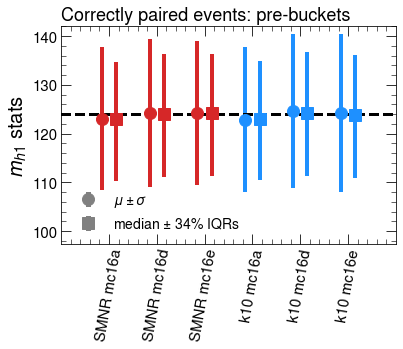

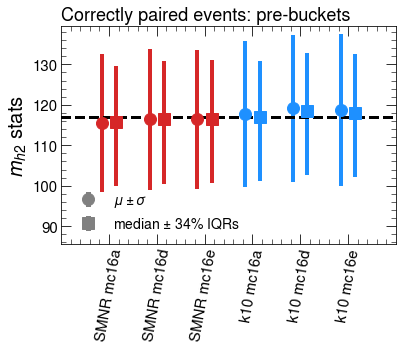

In [17]:
plotCenterSpreads(sumStats,'Correctly paired events: pre-buckets',
                  f'figures/SMNR_mc16ade-{prodTag}/min_dR/','summaryStats_fmp')

In [18]:
stats_50_200 = pd.DataFrame(0,idx,cols)

for physicsSample, dfs in zip(['SMNR','k10'],[[mc16a,mc16d,mc16e],[k10a,k10d,k10e]]):
    
    for mc,df in zip(['mc16a','mc16d','mc16e'],dfs):
        
        i = f'{physicsSample} {mc}'
        
        m = (df.ntag>=4) & (df.chosenPair==df.correctPair) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)
        
        for c in ['m_h1','m_h2']:

            mi = m & (df[c] > 50) & (df[c]< 200)
            
            v,w = df.loc[mi,[c,'mc_sf']].values.T

            weighted_stats = DescrStatsW(v, weights=w, ddof=0)

            stats_50_200.loc[i,f'{c} mu']     = weighted_stats.mean
            stats_50_200.loc[i,f'{c} std']    = weighted_stats.std
            
            median = weighted_stats.quantile(.5).values
            q_dn = weighted_stats.quantile(.5-.3414).values
            q_up = weighted_stats.quantile(.5+.3414).values
            
            stats_50_200.loc[i,f'{c} median'] = median
            
            stats_50_200.loc[i,f'{c} 34% dn'] = median-q_dn
            stats_50_200.loc[i,f'{c} 34% up'] = q_up-median
            stats_50_200.loc[i,f'{c} 1/2 68% IQR'] = (q_up-q_dn)/2
            

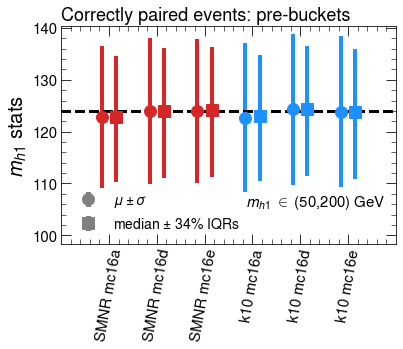

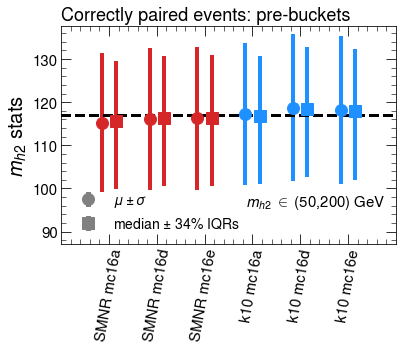

In [19]:
plotCenterSpreads(stats_50_200,'Correctly paired events: pre-buckets',
                  f'figures/SMNR_mc16ade-{prodTag}/min_dR/','50_200_summaryStats_fmp',
                  text='$\in$ (50,200) GeV')

**And now with resonant buckets**

In [20]:
stats_res = pd.DataFrame(0,idx,cols)

for physicsSample, dfs in zip(['SMNR','k10'],[[mc16a,mc16d,mc16e],[k10a,k10d,k10e]]):
    
    for mc,df in zip(['mc16a','mc16d','mc16e'],dfs):
        
        i = f'{physicsSample} {mc}'
        
        m = (df.bucket != 0)& (df.ntag>=4) & (df.chosenPair==df.correctPair) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)
        
        for c in ['m_h1','m_h2']:

            v,w = df.loc[m,[c,'mc_sf']].values.T

            weighted_stats = DescrStatsW(v, weights=w, ddof=0)

            stats_res.loc[i,f'{c} mu']     = weighted_stats.mean
            stats_res.loc[i,f'{c} std']    = weighted_stats.std
            
            median = weighted_stats.quantile(.5).values
            q_dn = weighted_stats.quantile(.5-.3414).values
            q_up = weighted_stats.quantile(.5+.3414).values
            
            
            stats_res.loc[i,f'{c} median'] = median
            
            stats_res.loc[i,f'{c} 34% dn'] = median-q_dn
            stats_res.loc[i,f'{c} 34% up'] = q_up-median
            stats_res.loc[i,f'{c} 1/2 68% IQR'] = (q_up-q_dn)/2
            

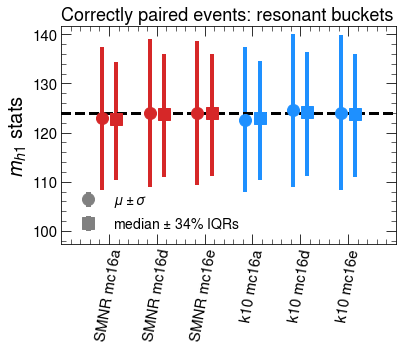

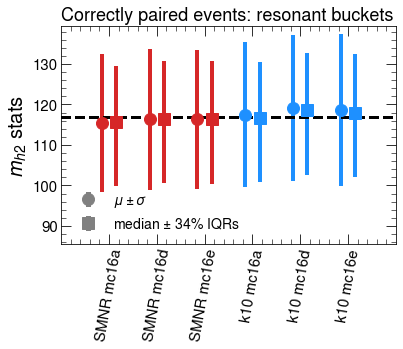

In [21]:
plotCenterSpreads(stats_res,'Correctly paired events: resonant buckets',
                  f'figures/SMNR_mc16ade-{prodTag}/min_dR/','summaryStats_resBuckets')

**Let's compare this to the no buckets correct means**

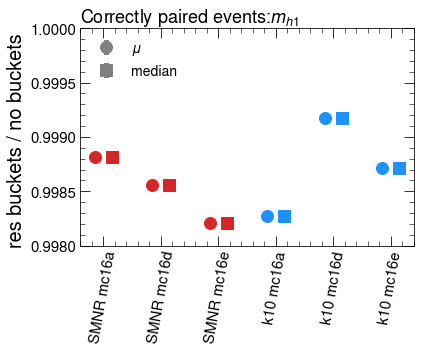

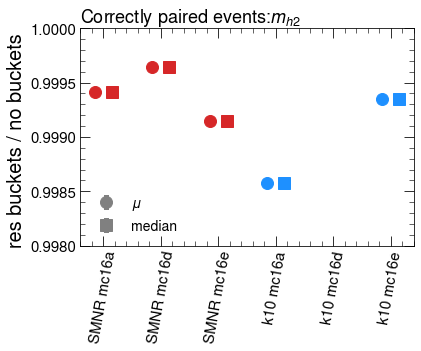

In [22]:
ms=12
dx=.15

for c,loc in zip(['m_h1','m_h2'],['upper left','lower left']):

    plt.figure()
    
    #First - the SM points
    plt.plot(np.arange(3)-dx,
             stats_res.loc[idx[:3],f'{c} mu']/sumStats.loc[idx[:3],f'{c} mu'],
             color='C3',lw=0,marker='o',markersize=ms)
    
    
    plt.plot(np.arange(3)+dx,
             stats_res.loc[idx[:3],f'{c} mu']/sumStats.loc[idx[:3],f'{c} mu'],
             color='C3',lw=0,marker='s',markersize=ms)


    # Next k10
    plt.plot(np.arange(3,6)-dx,
             stats_res.loc[idx[3:],f'{c} mu']/sumStats.loc[idx[3:],f'{c} mu'],
             color='dodgerblue',lw=0,marker='o',markersize=ms)

    
    plt.plot(np.arange(3,6)+dx,
             stats_res.loc[idx[3:],f'{c} mu']/sumStats.loc[idx[3:],f'{c} mu'],
             color='dodgerblue',lw=0,marker='s',markersize=ms)
    

    for marker,l in zip(['o','s'],['$\mu$','median']):
        plt.errorbar([],[],[],label=l,
                     color='grey',lw=0,elinewidth=5,marker=marker,markersize=ms)
    plt.legend(loc=loc)
    
    
    plt.xticks(range(6),stats_res.index,rotation=80)
    plt.ylabel('res buckets / no buckets ',fontsize=20)
    
    plt.title('Correctly paired events:$m_{h'+f'{c[-1]}'+'}$',loc='left')
    plt.ylim(.998,1)
    
    plt.savefig(f'figures/SMNR_mc16ade-{prodTag}/min_dR/{c}_ratio_resBuckets.pdf',bbox_inches='tight')

**What about with NR buckets?**

In [23]:
from triggerBuckets import trigger_lut

In [24]:
tDict = trigger_lut(17)

In [25]:
tDict

{'1b': 'HLT_j225_gsc300_bmv2c1070_split',
 '2b1j': 'HLT_j110_gsc150_boffperf_split_2j35_gsc55_bmv2c1070_split_L1J85_3J30',
 '2bHT': 'HLT_2j35_gsc55_bmv2c1050_split_ht300_L1HT190-J15s5.ETA21',
 '2b2j': 'HLT_2j15_gsc35_bmv2c1040_split_2j15_gsc35_boffperf_split_L14J15.0ETA25'}

In [26]:
for df,yr in zip([mc16a,mc16d,mc16e,k10a,k10d,k10e],[16,17,18]*2):
    
    tDict = trigger_lut(yr)
    
    df['nr_bucket'] = 0
    df.loc[(df.lead_pt>170)& (df[tDict['2b1j']]),'nr_bucket'] = 1
    df.loc[(df.lead_pt<170)& (df[tDict['2b2j']]),'nr_bucket'] = 2

In [27]:
stats_nr = pd.DataFrame(0,idx,cols)

for physicsSample, dfs in zip(['SMNR','k10'],[[mc16a,mc16d,mc16e],[k10a,k10d,k10e]]):
    
    for mc,df in zip(['mc16a','mc16d','mc16e'],dfs):
        
        i = f'{physicsSample} {mc}'
        
        m = (df.nr_bucket != 0)& (df.ntag>=4) & (df.chosenPair==df.correctPair) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)
        
        for c in ['m_h1','m_h2']:

            v,w = df.loc[m,[c,'mc_sf']].values.T

            weighted_stats = DescrStatsW(v, weights=w, ddof=0)

            stats_nr.loc[i,f'{c} mu']     = weighted_stats.mean
            stats_nr.loc[i,f'{c} std']    = weighted_stats.std
            
            median = weighted_stats.quantile(.5).values
            q_dn = weighted_stats.quantile(.5-.3414).values
            q_up = weighted_stats.quantile(.5+.3414).values
            
            
            stats_nr.loc[i,f'{c} median'] = median
            
            stats_nr.loc[i,f'{c} 34% dn'] = median-q_dn
            stats_nr.loc[i,f'{c} 34% up'] = q_up-median
            stats_nr.loc[i,f'{c} 1/2 68% IQR'] = (q_up-q_dn)/2
            

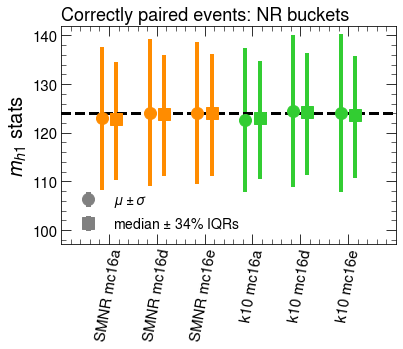

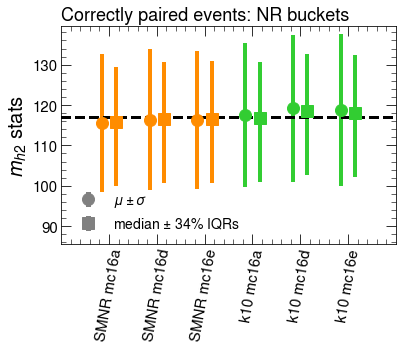

In [28]:
plotCenterSpreads(stats_nr,'Correctly paired events: NR buckets',
                  f'figures/SMNR_mc16ade-{prodTag}/min_dR/','summaryStats_nrBuckets',
                  c0='darkorange',c1='limegreen')

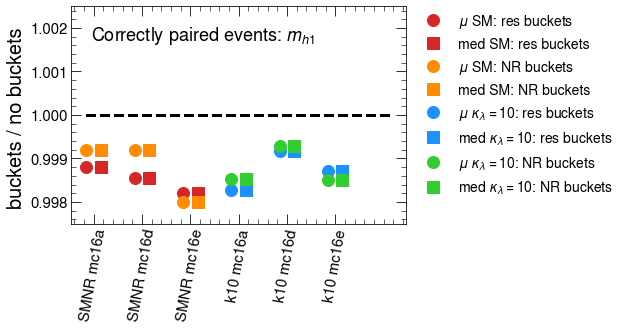

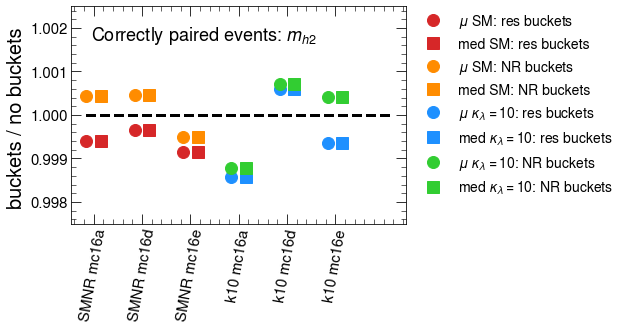

In [29]:
for c,loc in zip(['m_h1','m_h2'],['upper left','lower left']):

    plt.figure()
    
    #First - the SM points
    plt.plot(np.arange(3)-dx,
             stats_res.loc[idx[:3],f'{c} mu']/sumStats.loc[idx[:3],f'{c} mu'],
             color='C3',lw=0,marker='o',markersize=ms,label='$\mu$ SM: res buckets')
    
    
    plt.plot(np.arange(3)+dx,
             stats_res.loc[idx[:3],f'{c} mu']/sumStats.loc[idx[:3],f'{c} mu'],
             color='C3',lw=0,marker='s',markersize=ms,label='med SM: res buckets')
    
    plt.plot(np.arange(3)-dx,
             stats_nr.loc[idx[:3],f'{c} mu']/sumStats.loc[idx[:3],f'{c} mu'],
             color='darkorange',lw=0,marker='o',markersize=ms,label='$\mu$ SM: NR buckets')
    
    
    plt.plot(np.arange(3)+dx,
             stats_nr.loc[idx[:3],f'{c} mu']/sumStats.loc[idx[:3],f'{c} mu'],
             color='darkorange',lw=0,marker='s',markersize=ms,label='med SM: NR buckets')


    # Next k10
    plt.plot(np.arange(3,6)-dx,
             stats_res.loc[idx[3:],f'{c} mu']/sumStats.loc[idx[3:],f'{c} mu'],
             color='dodgerblue',lw=0,marker='o',markersize=ms,
             label='$\mu$ $\kappa_\lambda=10$: res buckets')

    
    plt.plot(np.arange(3,6)+dx,
             stats_res.loc[idx[3:],f'{c} mu']/sumStats.loc[idx[3:],f'{c} mu'],
             color='dodgerblue',lw=0,marker='s',markersize=ms,
             label='med $\kappa_\lambda=10$: res buckets')
    
    plt.plot(np.arange(3,6)-dx,
             stats_nr.loc[idx[3:],f'{c} mu']/sumStats.loc[idx[3:],f'{c} mu'],
             color='limegreen',lw=0,marker='o',markersize=ms,
             label='$\mu$ $\kappa_\lambda=10$: NR buckets')

    
    plt.plot(np.arange(3,6)+dx,
             stats_nr.loc[idx[3:],f'{c} mu']/sumStats.loc[idx[3:],f'{c} mu'],
             color='limegreen',lw=0,marker='s',markersize=ms,
             label='med $\kappa_\lambda=10$: NR buckets')
    
    plt.legend(bbox_to_anchor=(1,1.03))
    plt.plot([-dx,6+dx],[1]*2,'k--')
    
    plt.xticks(range(6),stats_res.index,rotation=80)
    plt.ylabel('buckets / no buckets ',fontsize=20)
    
    ax = plt.gca()
    plt.text(.06,.92,'Correctly paired events: $m_{h'+f'{c[-1]}'+'}$',
             ha='left',va='top',transform=ax.transAxes,fontsize=18)
    plt.ylim(.9975,1.0025)
    
    plt.savefig(f'figures/SMNR_mc16ade-{prodTag}/min_dR/{c}_ratio_nrBuckets.pdf',bbox_inches='tight')

In [30]:
.002*124

0.248

Let's make **1** plot to *demonstrate* that the dist is *more peaked* than a single Gaussian.

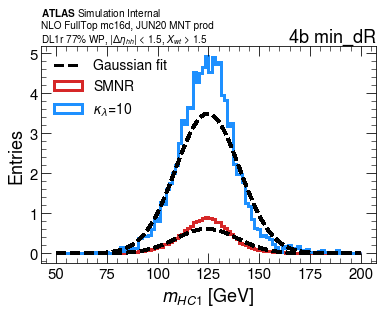

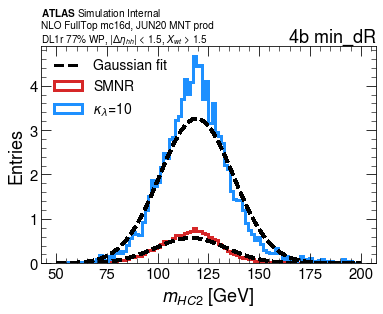

In [31]:
title='min_dR'
lw=3

mc='mc16d'

fmp = "$\mathbf{ATLAS}$ Simulation Internal\n"
fmp += f"NLO FullTop {mc}, {prodTag} MNT prod\n"
fmp += "DL1r 77% WP, $|\Delta \eta_{hh}|$ < 1.5, $X_{wt}$ > 1.5"



for c in ['m_h1','m_h2']:

    plt.figure()
    
    for physicsSample, df, color in zip(['SMNR','k10'],[mc16d,k10d],['C3','dodgerblue']):

        m = (df.ntag>=4) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5) & (df.chosenPair==df.correctPair)

        l = physicsSample if physicsSample == 'SMNR' else f'$\kappa_\lambda$={physicsSample[1:]}'
        n,e,_ = plt.hist(df.loc[m ,c], 100,(50,200),label=l,lw=lw,
                         color=color,histtype='step',weights=df.loc[m,'mc_sf'])

        xx = np.linspace(50,200)
        
        mu,std = sumStats.loc[f'{physicsSample} {mc}',[f'{c} mu',f'{c} std']]
        yy = 1/np.sqrt(2*np.pi * std) * np.exp(- 0.5 * ((xx-mu)/std)**2)
        
        # Overlay the Gaussian fit
        norm = np.sum(df.loc[m,'mc_sf']) / 3
        
        plt.plot(xx,norm*yy,'k--',label='Gaussian fit' if physicsSample=='SMNR' else '')
    
    
    plt.xlabel('$m_{HC'+f'{c[-1]}'+'}$ [GeV]',fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.legend(loc='upper left')

    ax = plt.gca()
    plt.title(f'4b {title}',transform=ax.transAxes,loc='right')
    plt.text(0,1,fmp,transform=ax.transAxes,ha='left',va='bottom',fontsize=10)
    
    figDir = f'figures/k10_{mc}-{prodTag}/{title}'
    
    plt.savefig(f'{figDir}/{c}_{ntag}b_Xwt_fittedGaussians.pdf', bbox_inches='tight')

    plt.show()

In [32]:
np.sum(norm*yy)

48.41019596379863

In [33]:
np.sum(n)

104.16364730049612

### Step 3: Make some massplanes

In [34]:
x0,y0 = 120, 110
x1,y1 = 124, 117

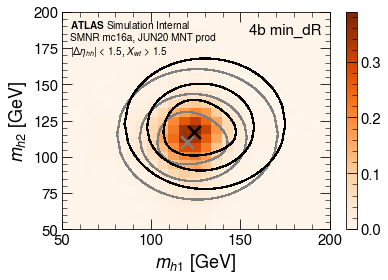

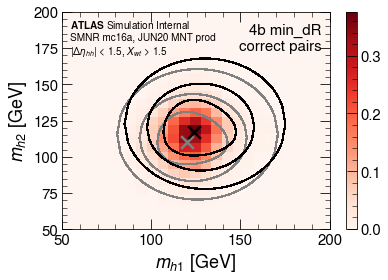

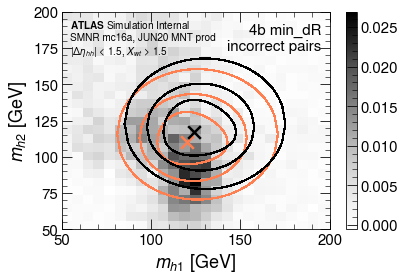

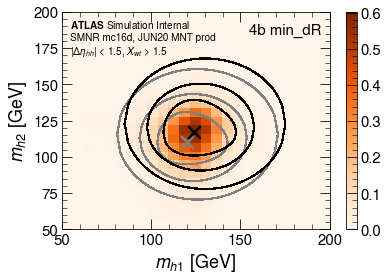

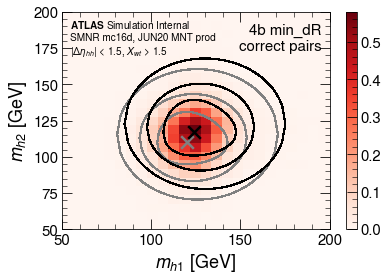

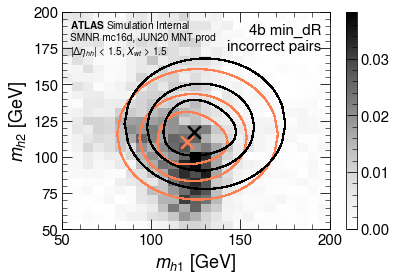

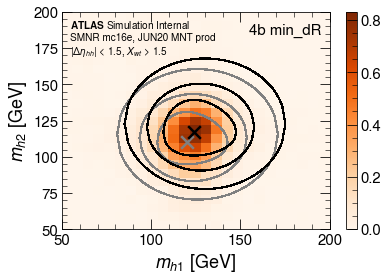

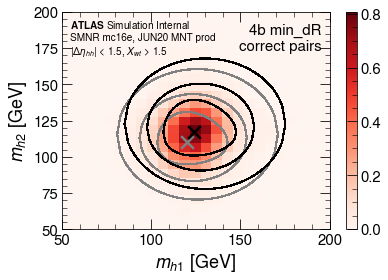

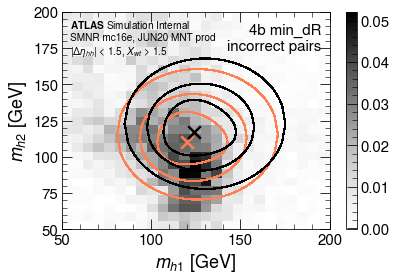

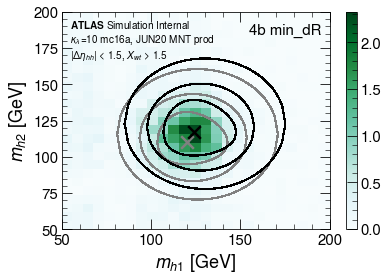

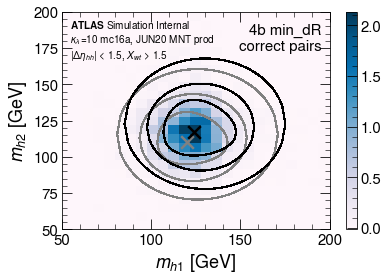

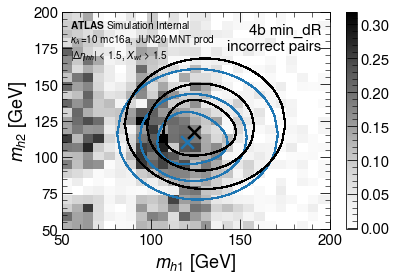

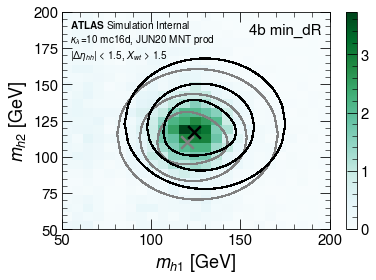

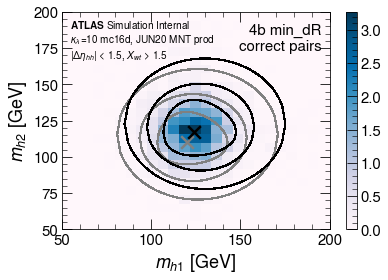

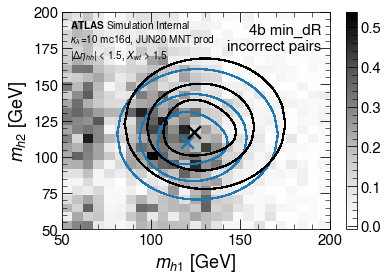

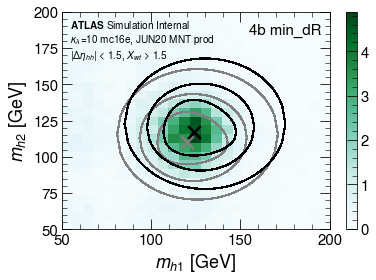

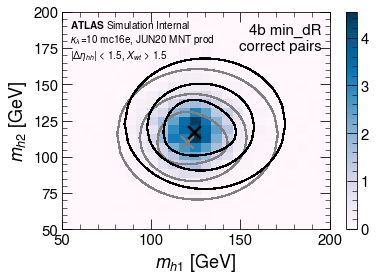

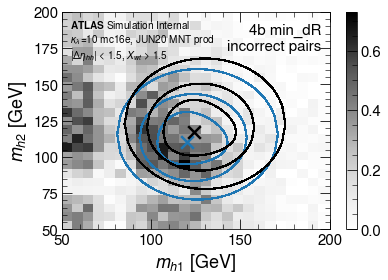

In [35]:
for physicsSample, dfs, c_all,c_correct,c0 in zip(['SMNR','k10'],[[mc16a,mc16d,mc16e],[k10a,k10d,k10e]],
                                                  ['Oranges','BuGn'],['Reds','PuBu'],['coral','C0']):

    ps = physicsSample if physicsSample == 'SMNR' else f'$\kappa_\lambda$={physicsSample[1:]}'

    lc = ['k', c0, c1]
    
    for mc,df in zip(['mc16a','mc16d','mc16e'],dfs):

        fmp = "$\mathbf{ATLAS}$ Simulation Internal\n"
        fmp += f"{ps} {mc}, {prodTag} MNT prod"
        fmp += "\n$|\Delta \eta_{hh}|$ < 1.5, $X_{wt}$ > 1.5"
        
        m = (df.ntag>=4) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)
        
        figDir = f'figures/{physicsSample}_{mc}-{prodTag}/{title}'
        
        for mi,cmap,ci,t,ti in zip([m,df.chosenPair==df.correctPair,df.chosenPair!=df.correctPair],
                                   [c_all,c_correct,'Greys'],['grey']*2+[c0],
                                   ['','\ncorrect pairs','\nincorrect pairs'],['','_corect','_incorrect']):
        
            plt.figure()
            plt.hist2d(*df.loc[m&mi,['m_h1','m_h2']].values.T,25,[(50,200),(50,200)],
                       cmap=cmap,weights=df.loc[m&mi,'mc_sf'])
            plt.colorbar()
            plt.xlabel('$m_{h1}$ [GeV]',fontsize=18)
            plt.ylabel('$m_{h2}$ [GeV]',fontsize=18)

            ax = plt.gca()
            plt.text(.97,.95,f'4b {title}{t}',transform=ax.transAxes,ha='right',va='top',fontsize=15)
            plt.text(0.03,0.97,fmp,transform=ax.transAxes,ha='left',va='top',fontsize=10)

            # Overlay our region definitions
            for xi,yi,c,rTag in zip([x0,x1],[y0,y1],[ci,'k'],['old','old_new']):
            
                plt.scatter([xi],[yi],160,marker='x',color=c)
                for f in [draw_SR,draw_VR,draw_CR]:
                    x,y = f(xi,yi)
                    plt.plot(x,y,c,lw=1.2)
            
                plt.savefig(f'{figDir}/mp_4b_Xwt{ti}{rTag}.pdf', bbox_inches='tight')


### Step 4: Look at $m_{hh}$ for the new and shifted SR (and maybe VR as well)

Add these new regions to the df!


In [36]:
from analysis import getRegions

In [37]:
for df in [mc16a,mc16d,mc16e,k10a,k10d,k10e]:

    for xi,yi in zip([120,124],[110,117]):

        kr = f'kr_{xi}_{yi}'
        getRegions(df,xi,yi,kr=kr)

SMNR old SR: correct below 350 GeV 0.033290085102236786
SMNR old SR: incorrect below 350 GeV 0.17085305947456533
SMNR new SR: correct below 350 GeV 0.022717449747174233
SMNR new SR: incorrect below 350 GeV 0.15842602013987367


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


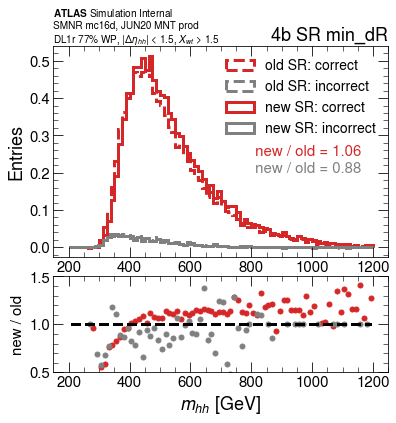

k10 old SR: correct below 350 GeV 0.12209350978877458
k10 old SR: incorrect below 350 GeV 0.4641135437519433
k10 new SR: correct below 350 GeV 0.09427022563367587
k10 new SR: incorrect below 350 GeV 0.41639142788825945


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


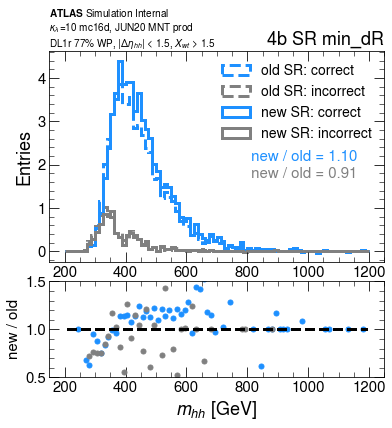

SMNR old VR: correct below 350 GeV 0.03566518905093949
SMNR old VR: incorrect below 350 GeV 0.2018473618825147
SMNR new VR: correct below 350 GeV 0.04721036728629517
SMNR new VR: incorrect below 350 GeV 0.18805152204368408


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


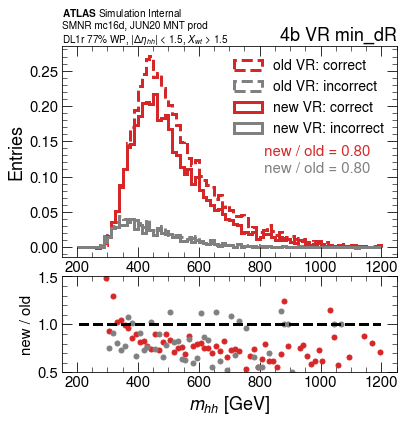

k10 old VR: correct below 350 GeV 0.11418062405671575
k10 old VR: incorrect below 350 GeV 0.470448646794718
k10 new VR: correct below 350 GeV 0.14710565007727092
k10 new VR: incorrect below 350 GeV 0.4481765906953276


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


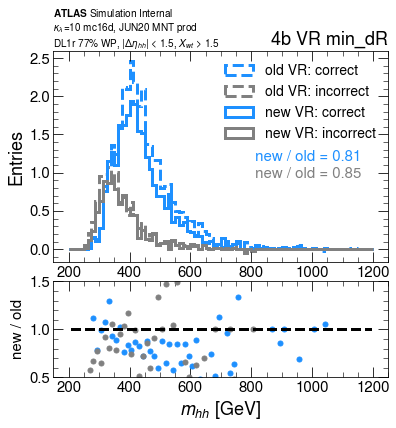

SMNR old CR: correct below 350 GeV 0.04334516953578998
SMNR old CR: incorrect below 350 GeV 0.15272783807618376
SMNR new CR: correct below 350 GeV 0.06081586545937424
SMNR new CR: incorrect below 350 GeV 0.1800049625794479


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


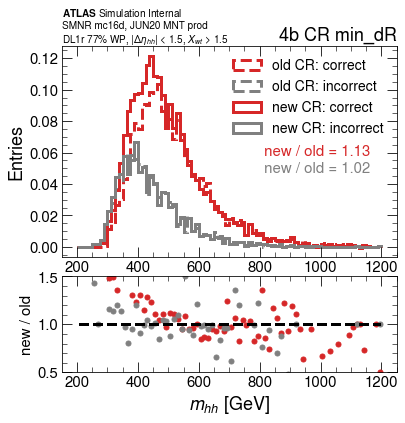

k10 old CR: correct below 350 GeV 0.10317244526934258
k10 old CR: incorrect below 350 GeV 0.4492430172975632
k10 new CR: correct below 350 GeV 0.1508636152503274
k10 new CR: incorrect below 350 GeV 0.4583255303187911


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


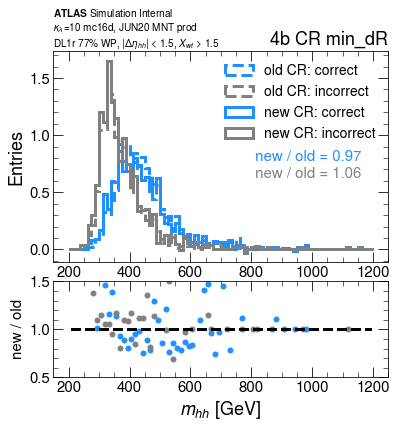

In [38]:
title='min_dR'
lw=3

mc='mc16d'

c = 'm_hh'


for i, region in enumerate(['SR','VR','CR']):

    for physicsSample, df, color in zip(['SMNR','k10'],[mc16d,k10d],['C3','dodgerblue']):

        ps = physicsSample if physicsSample == 'SMNR' else f'$\kappa_\lambda$={physicsSample[1:]}'

        fmp = "$\mathbf{ATLAS}$ Simulation Internal\n"
        fmp += f"{ps} {mc}, {prodTag} MNT prod\n"
        fmp += "DL1r 77% WP, $|\Delta \eta_{hh}|$ < 1.5, $X_{wt}$ > 1.5"

        fig = plt.figure(figsize=(6,6))
        gs = gridspec.GridSpec(3,1)
        ax1 = fig.add_subplot(gs[:2,0])
        ax2 = fig.add_subplot(gs[2,0],sharex=ax1)

        hDict = {}

        lc = [color,'grey']
        lt = []
        
        for l, xi,yi, ls in zip(['old','new'],[120,124],[110,117],['--','-']):

            kr = f'kr_{xi}_{yi}'

            m = (df.ntag>=4) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5) & (df[kr]==i)

            
            for mi,li,ci in zip([df.chosenPair==df.correctPair,df.chosenPair!=df.correctPair],
                                ['correct','incorrect'],lc):

                k = f'{l} {region}: {li}'
                n,e,_=ax1.hist(df.loc[m&mi ,c], 80,(200,1200),
                               label=k,lw=lw,color=ci,
                               ls=ls,histtype='step',weights=df.loc[m&mi,'mc_sf'])

                hDict[k] = n

                print(physicsSample,k,'below 350 GeV',np.sum(df.loc[m&mi&(df.m_hh<350),'mc_sf'])/np.sum(n))
                
                
        # Fill in  the ratio panel
        xx = 0.5 * (e[1:]+e[:-1])
        for li,color in zip(['correct','incorrect'],[color,'grey']):
            n_old = hDict[f'old {region}: {li}']
            n_new = hDict[f'new {region}: {li}']

            ax2.plot(xx,n_new/n_old,color,lw=0,marker='o',markersize=5)

            lt.append(f'new / old = {np.sum(n_new)/np.sum(n_old):.2f}')
            
            
        ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
        ax1.set_ylabel('Entries',fontsize=18)
        ax2.set_ylabel('new / old')
        ax1.legend(loc='upper right')

        ax2.plot(xx,np.ones_like(xx),'k--')
        ax2.set_ylim(.5,1.5)

        ax1.set_title(f'4b {region} {title}',loc='right')
        ax1.text(0,1,fmp,transform=ax1.transAxes,ha='left',va='bottom',fontsize=10)

        ymid = 0.5 * sum(ax1.get_ylim())
        rainbow_text(800,ymid,lt,lc,yoffset=1.2,ax=ax1,ha='left',va='center')
        
        figDir = f'figures/{physicsSample}_{mc}-{prodTag}/{title}'    
        plt.savefig(f'{figDir}/{c}_4b_correctIncorrect_{region}.pdf', bbox_inches='tight')

        plt.show()
          
#         break
#     break

In [39]:
np.sum(df.loc[m&mi,'mc_sf'])

13.989000710159265

SMNR old SR: correct below 350 GeV 0.03848658979866217
SMNR old SR: incorrect below 350 GeV 0.19594893189987858
SMNR new SR: correct below 350 GeV 0.026334144983920137
SMNR new SR: incorrect below 350 GeV 0.18151084480825333


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


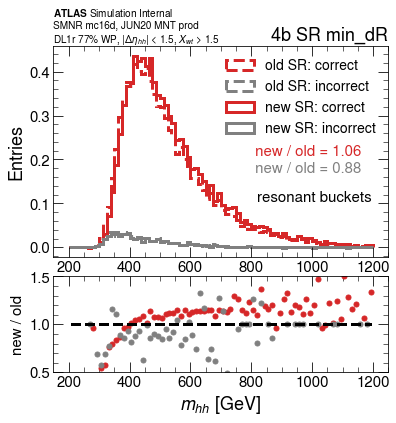

k10 old SR: correct below 350 GeV 0.1313715221435563
k10 old SR: incorrect below 350 GeV 0.49754795726682344
k10 new SR: correct below 350 GeV 0.10266281940532083
k10 new SR: incorrect below 350 GeV 0.45194496584184896


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


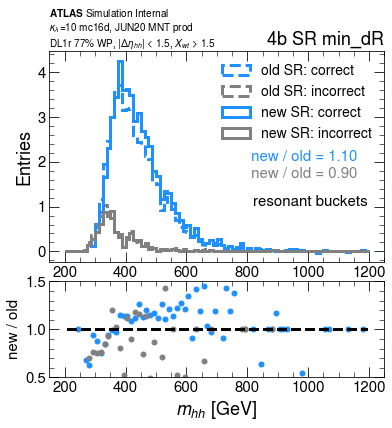

SMNR old VR: correct below 350 GeV 0.04058582808351626
SMNR old VR: incorrect below 350 GeV 0.23001646231995554
SMNR new VR: correct below 350 GeV 0.054109641409658744
SMNR new VR: incorrect below 350 GeV 0.21758143994175513


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


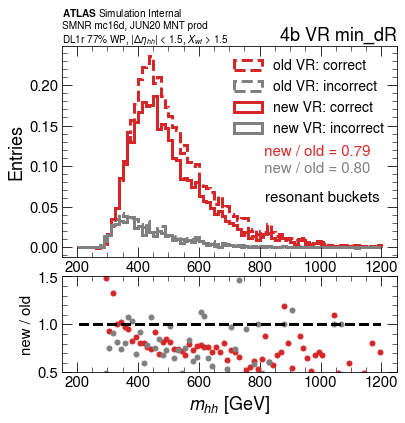

k10 old VR: correct below 350 GeV 0.12833245157079615
k10 old VR: incorrect below 350 GeV 0.5007009903043995
k10 new VR: correct below 350 GeV 0.1593498641143307
k10 new VR: incorrect below 350 GeV 0.4761109229633282


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


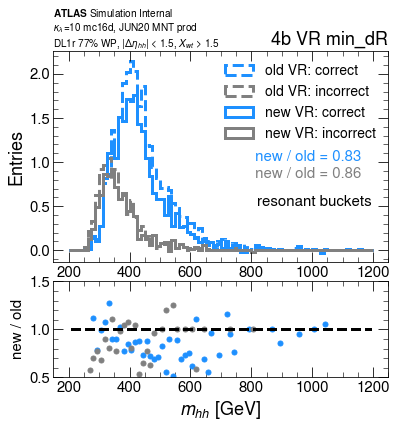

SMNR old CR: correct below 350 GeV 0.051631413896126035
SMNR old CR: incorrect below 350 GeV 0.17073424230536635
SMNR new CR: correct below 350 GeV 0.07111457116619097
SMNR new CR: incorrect below 350 GeV 0.19877306200473022


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


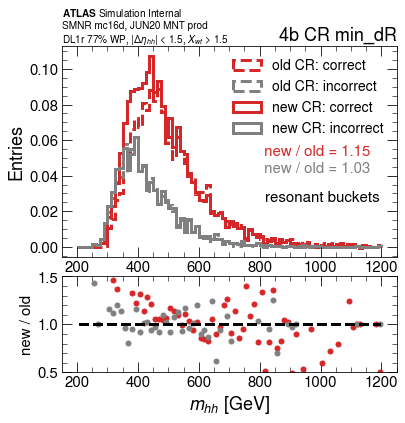

k10 old CR: correct below 350 GeV 0.11267785381495
k10 old CR: incorrect below 350 GeV 0.4720998949672891
k10 new CR: correct below 350 GeV 0.16697168620266287
k10 new CR: incorrect below 350 GeV 0.4763259362099572


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


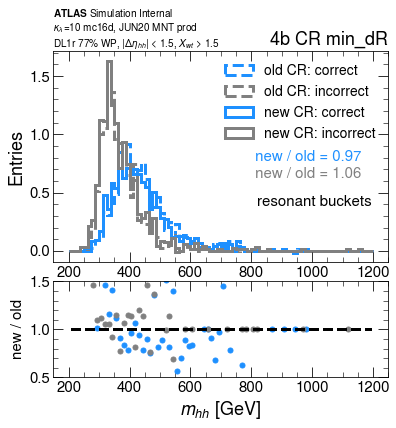

In [40]:
title='min_dR'
lw=3

mc='mc16d'

c = 'm_hh'


for i, region in enumerate(['SR','VR','CR']):

    for physicsSample, df, color in zip(['SMNR','k10'],[mc16d,k10d],['C3','dodgerblue']):

        ps = physicsSample if physicsSample == 'SMNR' else f'$\kappa_\lambda$={physicsSample[1:]}'

        fmp = "$\mathbf{ATLAS}$ Simulation Internal\n"
        fmp += f"{ps} {mc}, {prodTag} MNT prod\n"
        fmp += "DL1r 77% WP, $|\Delta \eta_{hh}|$ < 1.5, $X_{wt}$ > 1.5"

        fig = plt.figure(figsize=(6,6))
        gs = gridspec.GridSpec(3,1)
        ax1 = fig.add_subplot(gs[:2,0])
        ax2 = fig.add_subplot(gs[2,0],sharex=ax1)

        hDict = {}

        lc = [color,'grey']
        lt = []
        
        for l, xi,yi, ls in zip(['old','new'],[120,124],[110,117],['--','-']):

            kr = f'kr_{xi}_{yi}'

            m = (df.ntag>=4) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5) & (df[kr]==i) & (df.bucket!=0)

            
            for mi,li,ci in zip([df.chosenPair==df.correctPair,df.chosenPair!=df.correctPair],
                                ['correct','incorrect'],lc):

                k = f'{l} {region}: {li}'
                n,e,_=ax1.hist(df.loc[m&mi ,c], 80,(200,1200),
                               label=k,lw=lw,color=ci,
                               ls=ls,histtype='step',weights=df.loc[m&mi,'mc_sf'])

                hDict[k] = n

                print(physicsSample,k,'below 350 GeV',np.sum(df.loc[m&mi&(df.m_hh<350),'mc_sf'])/np.sum(n))
                
                
        # Fill in  the ratio panel
        xx = 0.5 * (e[1:]+e[:-1])
        for li,color in zip(['correct','incorrect'],[color,'grey']):
            n_old = hDict[f'old {region}: {li}']
            n_new = hDict[f'new {region}: {li}']

            ax2.plot(xx,n_new/n_old,color,lw=0,marker='o',markersize=5)

            lt.append(f'new / old = {np.sum(n_new)/np.sum(n_old):.2f}')
            
            
        ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
        ax1.set_ylabel('Entries',fontsize=18)
        ax2.set_ylabel('new / old')
        ax1.legend(loc='upper right')

        ax2.plot(xx,np.ones_like(xx),'k--')
        ax2.set_ylim(.5,1.5)

        ax1.set_title(f'4b {region} {title}',loc='right')
        ax1.text(0,1,fmp,transform=ax1.transAxes,ha='left',va='bottom',fontsize=10)

        ymid = 0.5 * sum(ax1.get_ylim())
        rainbow_text(800,ymid,lt,lc,yoffset=1.2,ax=ax1,ha='left',va='center')
        
        ax1.text(.95,.25,'resonant buckets',ha='right',va='bottom',transform=ax1.transAxes)
        
        figDir = f'figures/{physicsSample}_{mc}-{prodTag}/{title}'    
        plt.savefig(f'{figDir}/{c}_4b_correctIncorrect_{region}_resBuckets.pdf', bbox_inches='tight')

        plt.show()
          
#         break
#     break

### Step 5: Look for some intuition for the $X_{hh}$ cut value

Ok, the paper said these value on the JES / JER were chosen st we have a ...


In [7]:
jer_df = pd.read_csv('../figures/JER_info/PFlow_JER.csv',header=None,
                     names=['pT','JER'])

In [8]:
# pT_x = jer_df.pT.values.reshape(-1,1,1)

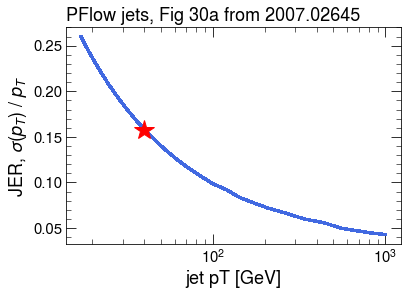

In [9]:
plt.semilogx(jer_df.pT,jer_df['JER'],'royalblue')
plt.xlabel('jet pT [GeV]',fontsize=18)
plt.ylabel('JER, $\sigma (p_T)$ / $p_T$',fontsize=18)#,loc='right')
plt.title('PFlow jets, Fig 30a from 2007.02645',loc='left')

# Sanity check I know how to retrieve these values
pti = 40
i_loc = np.argmin(np.abs(jer_df.pT - pti))
jer = jer_df.JER[i_loc]
plt.plot([pti],[jer],'r',marker='*',markersize=20)

However, since the b-jet often decays semi-leptonically, we *know* the JER, is worse for b-jets, so Jannicke shared a plot w/ me that I was able to scrape the points off of.

In [10]:
pre = pd.read_csv('../figures/JER_info/PreRegression.csv',header=None, names=['pT','JER'])
reg = pd.read_csv('../figures/JER_info/Regression.csv',header=None, names=['pT','JER'])

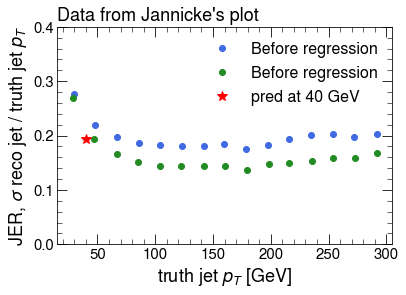

In [11]:
plt.plot(pre.pT,pre['JER'],'royalblue',lw=0,marker='o',label='Before regression')
plt.plot(reg.pT,reg['JER'],'forestgreen',lw=0,marker='o',label='Before regression')
plt.xlabel('truth jet $p_T$ [GeV]',fontsize=18)
plt.ylabel('JER, $\sigma$ reco jet / truth jet $p_T$',fontsize=18)
plt.title('Data from Jannicke\'s plot',loc='left')

plt.ylim(0,.4)

# Sanity check for retrieving these values
pti = 40
i_loc = np.argmin(np.abs(reg.pT - pti))
jer = reg.JER[i_loc]
plt.plot([pti],[jer],'r',marker='*',lw=0,markersize=10,label='pred at 40 GeV')

plt.legend(fontsize=16)
plt.show()

Since we have b-jets in the analysis, probably should use Jannicke's regression for this study.

In [12]:
pT_x = reg.pT.values.reshape(-1,1,1)

Note - to get the JERs corresponding to *all* of the jet $p_T$s, we'd probably want to do some broadcasting!

In [13]:
# df = mc16d
# my_title = '4b min_dR: SM mc16d, correct pairs'

df = k10d
my_title = '4b min_dR: $\kappa_\lambda$=10 mc16d, correct pairs'
#figDir = f'figures/'

In [14]:
jpts = df[['pt_h1_j1','pt_h1_j2','pt_h2_j1','pt_h2_j2']].values.reshape(1,-1,4)

In [15]:
idx = np.argmin(np.abs(pT_x-jpts),axis=0).squeeze()

In [16]:
jers = jer_df['JER'].values[idx]

Look after all of the anlaysis cuts.

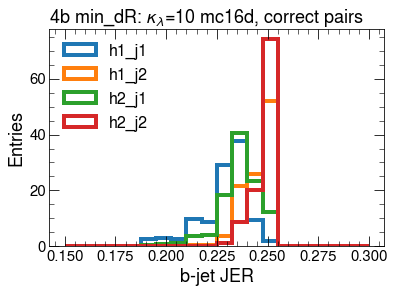

In [17]:
m = (df.ntag>=4) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5) & (df.correctPair==df.chosenPair)

for i,l in zip(range(4),['h1_j1','h1_j2','h2_j1','h2_j2']):
    plt.hist(jers[m,i],20,(.15,.3),color=f'C{i}',histtype='step',
             lw=4,label=l,weights=df.loc[m,'mc_sf'])
    
plt.xlabel('b-jet JER',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.legend(loc='upper left',fontsize=16)
plt.title(my_title,loc='left')
plt.show()

In [18]:
df['h1_jer'] = np.sqrt(np.sum(jers[:,:2]**2,axis=1))
df['h2_jer'] = np.sqrt(np.sum(jers[:,2:]**2,axis=1))

In [19]:
redgs = np.arange(.3,.365,.01)

(-1.1641420814556027, 23.859319265231044)

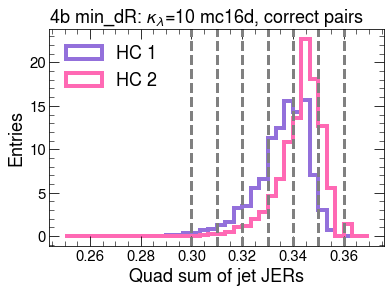

In [20]:
plt.hist(df.loc[m,'h1_jer'],36,(.25,.37),color='mediumpurple',histtype='step',
         lw=4,label='HC 1',weights=df.loc[m,'mc_sf'])

plt.hist(df.loc[m,'h2_jer'],36,(.25,.37),color='hotpink',histtype='step',
         lw=4,label='HC 2',weights=df.loc[m,'mc_sf'])

plt.legend(fontsize=18)
plt.xlabel('Quad sum of jet JERs',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.title(my_title,loc='left')

ylim = plt.ylim()
for ri in redgs:
    plt.plot([ri]*2,ylim,color='grey',ls='--')
plt.ylim(ylim)

In [21]:
mid_jers = 0.05*(redgs[1:]+redgs[:-1])
hcDict = {k:[] for k in [f'h{i}_{v}' for i,v in product([1,2],['mu','std','med','dn','up','iqr'])]}

for r_min,r_max in zip(redgs[:-1],redgs[1:]):
    
    for i in [1,2]:
        
        mi = m & (df[f'h{i}_jer'] > r_min) & (df[f'h{i}_jer'] < r_max)

        wstats = DescrStatsW(*df.loc[mi,[f'm_h{i}','mc_sf']].values.T, ddof=0)

        hcDict[f'h{i}_mu'].append(wstats.mean)
        hcDict[f'h{i}_std'].append(wstats.std)

        median = wstats.quantile(.5).values
        q_dn = wstats.quantile(.5-.3414).values
        q_up = wstats.quantile(.5+.3414).values

        hcDict[f'h{i}_med'].append(median)
        hcDict[f'h{i}_dn'].append(median-q_dn)
        hcDict[f'h{i}_up'].append(q_up-median)
        hcDict[f'h{i}_iqr'].append(0.5*(q_up-q_dn))
        
        
for k in hcDict.keys():
    hcDict[k] = np.array(hcDict[k])


^ Hmmmm - should I vis this w/ a 2x4 plot??

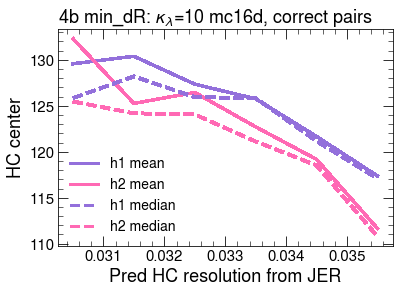

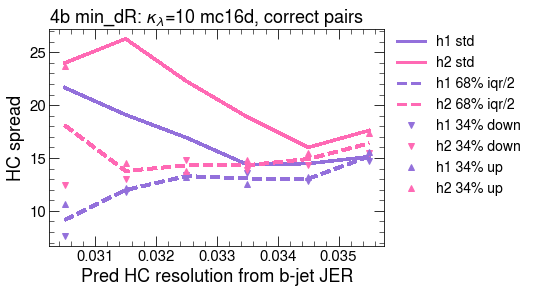

In [22]:
plt.figure()
plt.plot(mid_jers,hcDict['h1_mu'],'mediumpurple',label='h1 mean')
plt.plot(mid_jers,hcDict['h2_mu'],'hotpink',label='h2 mean')

plt.plot(mid_jers,hcDict['h1_med'],'mediumpurple',ls='--',label='h1 median')
plt.plot(mid_jers,hcDict['h2_med'],'hotpink',ls='--',label='h2 median')

plt.xlabel('Pred HC resolution from JER',fontsize=18)
plt.ylabel('HC center',fontsize=18)
plt.title(my_title,loc='left')
plt.legend(loc='best')

plt.figure()
plt.plot(mid_jers,hcDict['h1_std'],'mediumpurple',label='h1 std')
plt.plot(mid_jers,hcDict['h2_std'],'hotpink',label='h2 std')

plt.plot(mid_jers,hcDict['h1_iqr'],'mediumpurple',ls='--',label='h1 68% iqr/2')
plt.plot(mid_jers,hcDict['h2_iqr'],'hotpink',ls='--',label='h2 68% iqr/2')

plt.plot(mid_jers,hcDict['h1_dn'],'mediumpurple',lw=0,marker='v',label='h1 34% down')
plt.plot(mid_jers,hcDict['h2_dn'],'hotpink',lw=0,marker='v',label='h2 34% down')

plt.plot(mid_jers,hcDict['h1_up'],'mediumpurple',lw=0,marker='^',label='h1 34% up')
plt.plot(mid_jers,hcDict['h2_up'],'hotpink',lw=0,marker='^',label='h2 34% up')


plt.xlabel('Pred HC resolution from b-jet JER',fontsize=18)
plt.ylabel('HC spread',fontsize=18)
plt.title(my_title,loc='left')
plt.legend(bbox_to_anchor=(1,1.03))
plt.show()

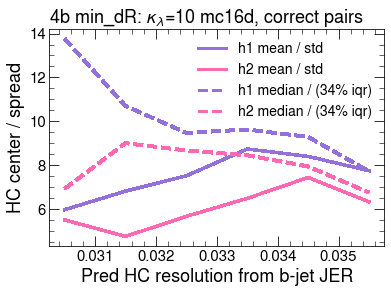

In [23]:
plt.figure()
plt.plot(mid_jers,hcDict['h1_mu']/hcDict['h1_std'],'mediumpurple',label='h1 mean / std')
plt.plot(mid_jers,hcDict['h2_mu']/hcDict['h2_std'],'hotpink',label='h2 mean / std')

plt.plot(mid_jers,hcDict['h1_med']/hcDict['h1_iqr'],'mediumpurple',ls='--',label='h1 median / (34% iqr)')
plt.plot(mid_jers,hcDict['h2_med']/hcDict['h2_iqr'],'hotpink',ls='--',label='h2 median / (34% iqr)')

plt.xlabel('Pred HC resolution from b-jet JER',fontsize=18)
plt.ylabel('HC center / spread',fontsize=18)
plt.title(my_title,loc='left')
plt.legend(loc='upper right')
plt.show()